## Canny 边缘检测

-----
* [https://www.cnblogs.com/techyan1990/p/7291771.html](https://www.cnblogs.com/techyan1990/p/7291771.html)

-----

### 第一步——边缘强度

-----

canny 边缘检测基本步骤：
> 1.使用高斯滤波；  
> 2.在x方向和y方向上使用 Sobel 滤波器，在此之上求出边缘的强度和边缘的梯度；  
> 3.对梯度幅值进行非极大值抑制（Non-maximum suppression）来使边缘变得更细；
> 4.使用滞后阈值来对阈值进行处理。

上面就是图像边缘检测的方法了。在这里我们先完成第一步和第二步。按照以下步骤进行处理：
> 1.将图像进行灰度化处理
> 2.将图像进行高斯滤波（5x 5,s=1.4);

图像中的边缘可以指向各个方向，因此Canny算法使用四个算子来检测图像中的水平、垂直和对角边缘。边缘检测的算子（如Roberts，Prewitt，Sobel等）返回水平Gx和垂直Gy方向的一阶导数值，由此便可以确定像素点的梯度G和方向theta
> 3.在x方向和y方向上使用 Sobel 滤波器，在此之上求出边缘梯度fx和fy。边缘梯度可以按照下式求得：

```
梯度幅值 edge = sqrt(fx^2 + fy^2)
梯度方向 tan = arctan(fy / fx)
```
Sobel算子：

$$
S_{x}=\left[\begin{array}{ccc}{-1} & {0} & {1} \\ {-2} & {0} & {2} \\ {-1} & {0} & {1}\end{array}\right] \quad S_{y}=\left[\begin{array}{ccc}{1} & {2} & {1} \\ {0} & {0} & {0} \\ {-1} & {-2} & {-1}\end{array}\right]
$$

其中Sx表示x方向的Sobel算子，用于检测y方向的边缘；Sy表示y方向的Sobel算子，用于检测x方向的边缘（边缘方向和梯度方向垂直）            

> 4.使用下面的公式将梯度方向量化：

```
angle = {   0  (if -0.4142 < tan <= 0.4142)
           45  (if  0.4142 < tan < 2.4142)
           90  (if  |tan| >= 2.4142)
          135  (if -2.4142 < tan <= -0.4142)
```

In [1]:
# -*- coding: UTF-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in arctan


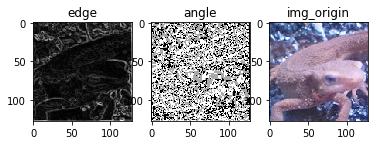

In [2]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()
(H, W, C) = img.shape

Sx = np.array([[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
Sy = np.array([[1, 2, 1],
     [0, 0, 0],
     [-1, -2,-1]])

# 灰度化
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 高斯滤波
img_GaussianBlur=cv2.GaussianBlur(gray,(5,5),0)

Gx = np.zeros((H, W), dtype=np.float32)
Gy = np.zeros((H, W), dtype=np.float32)

# zero padding
padding = 1 
img_padding = np.zeros((H + padding*2, W + padding*2), dtype=np.uint8)
img_padding[padding: padding + H, padding: padding + W] = gray.copy().astype(np.uint8)

for h in range(H):
    for w in range(W):
        Gx[h, w] = np.sum(img_padding[h: h + 3, w : w + 3] * Sx)
        Gy[h, w] = np.sum(img_padding[h: h + 3, w : w + 3] * Sy)

# 梯度幅值
edge = np.sqrt(Gx ** 2 + Gy ** 2)
# 梯度方向
tan = np.arctan(Gy / Gx)
Gx[Gx == 0] = np.e ** (-5)
angle = tan.copy()
angle[(angle > -0.4142) & (angle <= 0.4142)] = 0
angle[(angle > 0.4142) & (angle <= 2.4142)] = 45
angle[(angle > 2.4142) | (angle <= -2.4142)] = 90
angle[(angle > -2.4142) & (angle <= -0.4142)] = 135

angle = angle.astype(np.uint8)

img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)

plt.figure()
plt.subplot(131)
plt.imshow(edge, cmap="gray")
plt.title("edge")
plt.subplot(132)
plt.imshow(angle, cmap="gray")
plt.title("angle")
plt.subplot(133)
plt.imshow(img_origin)
plt.title("img_origin")
plt.show()

### 第二步---边缘细化
----


对梯度幅值进行非极大值抑制（Non-maximum suppression）来使边缘变得更细  

非极大值抑制是对除去非极大值以外的值的操作的总称  

非极大值抑制是一种边缘稀疏技术，非极大值抑制的作用在于“瘦”边。对图像进行梯度计算后，仅仅基于梯度值提取的边缘仍然很模糊

而非极大值抑制则可以帮助**将局部最大值之外的所有梯度值抑制为0**,对梯度图像中每个像素进行非极大值抑制的算法是:

> 1) 将当前像素的梯度强度与沿正负梯度方向上的两个像素进行比较。

> 2) 如果当前像素的梯度强度与另外两个像素相比最大，则该像素点保留为边缘点，否则该像素点将被抑制。

**通常为了更加精确的计算，在跨越梯度方向的两个相邻像素之间使用线性插值来得到要比较的像素梯度**  

但本方法采用量化方向的方式进行


[[  0.        0.        0.      ... 572.1993  525.50354   0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.      140.06427 ...   0.        0.        0.     ]
 ...
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]]


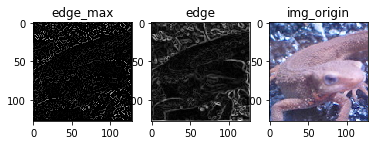

In [3]:
edge_max = np.zeros_like(edge)
(x, y) = np.where(angle[1:128, 1:128] == 0)
new_x = x[(edge[x, y] > edge[x-1, y]) & (edge[x, y] > edge[x+1, y])]
new_y = y[(edge[x, y] > edge[x-1, y]) & (edge[x, y] > edge[x+1, y])]
edge_max[new_x, new_y] = edge[new_x, new_y]
(x, y) = np.where(angle[1:128, 1:128] == 45)
new_x = x[(edge[x, y] > edge[x-1, y-1]) & (edge[x, y] > edge[x+1, y+1])]
new_y = y[(edge[x, y] > edge[x-1, y-1]) & (edge[x, y] > edge[x+1, y+1])]
edge_max[new_x, new_y] = edge[new_x, new_y]
(x, y) = np.where(angle[1:128, 1:128] == 90)
new_x = x[(edge[x, y] > edge[x, y-1]) & (edge[x, y] > edge[x, y+1])]
new_y = y[(edge[x, y] > edge[x, y-1]) & (edge[x, y] > edge[x, y+1])]
edge_max[new_x, new_y] = edge[new_x, new_y]
(x, y) = np.where(angle[1:128, 1:128] == 135)
new_x = x[(edge[x, y] > edge[x-1, y-1]) & (edge[x, y] > edge[x+1, y+1])]
new_y = y[(edge[x, y] > edge[x-1, y-1]) & (edge[x, y] > edge[x+1, y+1])]
edge_max[new_x, new_y] = edge[new_x, new_y]

print(edge_max)

    
plt.figure()
plt.subplot(131)
plt.imshow(edge_max, cmap="gray")
plt.title("edge_max")
plt.subplot(132)
plt.imshow(edge, cmap="gray")
plt.title("edge")
plt.subplot(133)
plt.imshow(img_origin)
plt.title("img_origin")
plt.show()

### Q43第三步——滞后阈值
----

在这里我们将通过设置高阈值和低阈值来将梯度幅值二值化

> 1.如果梯度幅值edge(x,y)大于高阈值的话，令edge(x,y)=255；
> 2.如果梯度幅值edge(x,y)小于低阈值的话，令edge(x,y)=0；
> 3.如果梯度幅值edge(x,y)介于高阈值和低阈值之间并且周围8邻域内有比高阈值高的像素点存在，令edge(x,y)=255, 否则edge(x,y)=0；

在这里，我们使高阈值为100，低阈值为30

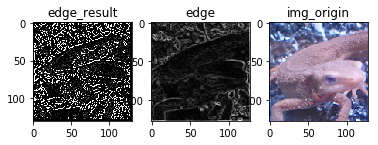

In [4]:
# Histeresis threshold
HT = 100
LT = 30
edge_result = np.zeros((H+2, W+2), dtype=np.float)
edge_result[1:H+1, 1:W+1] = edge_max
edge_result[edge_result >= HT] = 255
edge_result[edge_result < LT] = 0
(X, Y) = np.where((edge_result[1:128] < HT) & (edge_result[1:128] > LT))
for i in range(len(X)):
    if edge_result[x[i]-1:x[i]+1, y[i]-1:y[i]+1].any() > HT:
        edge_result[x[i], y[i]] == 255
    else:
        edge_result[x[i], y[i]] == 0

plt.figure()
plt.subplot(131)
plt.imshow(edge_result, cmap="gray")
plt.title("edge_result")
plt.subplot(132)
plt.imshow(edge, cmap="gray")
plt.title("edge")
plt.subplot(133)
plt.imshow(img_origin)
plt.title("img_origin")
plt.show()

### opencv 实现


---

* [https://blog.csdn.net/duwangthefirst/article/details/79971212](https://blog.csdn.net/duwangthefirst/article/details/79971212)

* [https://blog.51cto.com/weiyuqingcheng/2335243](https://blog.51cto.com/weiyuqingcheng/2335243)

---
它接受灰度图像作为输入，并使用多级算法
```python
edges = cv.Canny( image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]
                 
edges = cv.Canny(dx, dy, threshold1, threshold2[, edges[, L2gradient]])
```
              
> * image-是输入图像
> * threshold1 - 滞后阈值的低阈值
> * threshold2 - 滞后阈值的高阈值
> * apertureSize=3- Sober算子大小
> * L2gradient=false - 是否采用更精确的方式计算图像梯度//它可以用来设定 求梯度大小的方程。如果设为 True，就会使用我们上面提到过的方程，否则 使用方程：Edge−Gradient(G) = |G2 x | + |G2 y | 代替，默认值为 False


> * dx - 输入图像在x方向的导数
> * dy - 输入图像在y方向的导数

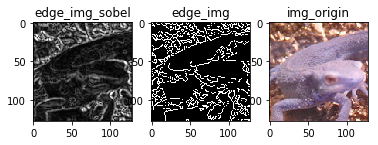

In [5]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()

# *******************Sobel边缘检测*******************
gausblur_img = cv2.GaussianBlur(img, (3, 3), 0 )

#转换为灰度图
channels = img.shape[2]
if channels > 1:
    src_gray = cv2.cvtColor(gausblur_img, cv2.COLOR_RGB2GRAY )
else:
    src_gray = src.copy()

scale = 1
delta = 0
depth = cv2.CV_16S

#求X方向梯度（创建grad_x, grad_y矩阵）
grad_x = cv2.Sobel( src_gray, depth, 1, 0 )
abs_grad_x = cv2.convertScaleAbs( grad_x )

#求Y方向梯度
grad_y = cv2.Sobel( src_gray, depth, 0, 1 )
abs_grad_y = cv2.convertScaleAbs( grad_y )

# 合并梯度
edge_img_sobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

# *****************canny 边缘检测**************
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
edge_img = cv2.Canny(blur, 50, 150)


plt.figure()
plt.subplot(131)
plt.imshow(edge_img_sobel, cmap="gray")
plt.title("edge_img_sobel")
plt.subplot(132)
plt.imshow(edge_img, cmap="gray")
plt.title("edge_img")
plt.subplot(133)
plt.imshow(img_origin)
plt.title("img_origin")
plt.show()